## Описание проекта

Интернет-магазин проводит массовые рассылки клиентам.
Задача проекта — построить модель, которая будет предсказывать вероятность совершения клиентом покупки в течение 90 дней после рассылки.

**Цель проекта:** разработать алгоритм прогнозирования отклика на рассылку, позволяющий повысить эффективность маркетинговых кампаний

# 1.Загрузка данных

In [1]:
!pip install phik -q

In [2]:
!pip install catboost lightgbm phik

In [3]:
!pip -q install shap

In [4]:
import pandas as pd
import os
import gdown
import ast
import phik
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import shap

from datetime import datetime
from functools import reduce
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


# 2.Изучение датафрейма apparel-messages

In [5]:
file_id = "18VXr3S3FXi2RovLPaGQV_cRqndkH-WlZ"
out_path = "/content/apparel-messages.csv"

# Скачаю файл. Не знаю иных путей, не читает со ссылки, большой файл. Я работала через Google Colab, у меня на компе памяти не хватает
gdown.download(id=file_id, output=out_path, quiet=False, fuzzy=True)

mess_df = pd.read_csv(out_path, low_memory=False, parse_dates=['created_at', 'date'])

Downloading...
From (original): https://drive.google.com/uc?id=18VXr3S3FXi2RovLPaGQV_cRqndkH-WlZ
From (redirected): https://drive.google.com/uc?id=18VXr3S3FXi2RovLPaGQV_cRqndkH-WlZ&confirm=t&uuid=9d59b1f8-8333-4af9-b562-7eaba0ab2fc4
To: /content/apparel-messages.csv
100%|██████████| 1.41G/1.41G [00:25<00:00, 55.4MB/s]


In [6]:
pd.set_option('display.max_columns', None)
mess_df.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [7]:
mess_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [8]:
num_duplicates = mess_df.duplicated().sum()
percent_duplicates = (num_duplicates / len(mess_df)) * 100
print(f"Количество дубликатов: {num_duplicates}")
print(f"Процент дубликатов: {percent_duplicates:.2f}%")

Количество дубликатов: 48610
Процент дубликатов: 0.38%


Полные дубликаты  удалю, так как совпадают даты создания вплоть до секунд, такого быть не может, это точно на удаление

In [9]:
mess_df.drop_duplicates(inplace=True)
mess_df.shape

(12691188, 7)

Удалю также колонку created_at, она нужна была для поиска полных дубликатов и далее просто дублирует информацию в столбце date

In [10]:
mess_df = mess_df.drop(columns=['created_at'])

In [11]:
mess_df['date'] = pd.to_datetime(mess_df['date'])

In [12]:
list(mess_df.columns)

['bulk_campaign_id', 'client_id', 'message_id', 'event', 'channel', 'date']

In [13]:
for col in mess_df.columns:
    print(f"{col}: {mess_df[col].nunique()}")

bulk_campaign_id: 2709
client_id: 53329
message_id: 9061667
event: 11
channel: 2
date: 638


In [14]:
mess_df['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

In [15]:
mess_df['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

In [16]:
mess_df.isna().sum()

,0
bulk_campaign_id,0
client_id,0
message_id,0
event,0
channel,0
date,0


Поработаю над агрегацией признаков из столбца event. Не хочу создавать много признаков, думаю суммировать положительные, отрицательные и нейтральные события и посчитать их количество для id, а также добавлю соотношения

In [17]:
positive = ['open', 'click', 'purchase', 'subscribe']
negative = ['unsubscribe', 'hbq_spam', 'hard_bounce', 'soft_bounce', 'complain']
neutral = ['send', 'close']

event_mess_df = (
    mess_df.groupby('client_id')
          .agg(
              positive_events=('event', lambda x: x.isin(positive).sum()),
              negative_events=('event', lambda x: x.isin(negative).sum()),
              neutral_events=('event', lambda x: x.isin(neutral).sum())
          )
          .reset_index()
)

event_mess_df['total_events'] = (
    event_mess_df['positive_events'] +
    event_mess_df['negative_events'] +
    event_mess_df['neutral_events']
)

event_mess_df['positive_ratio'] = event_mess_df['positive_events'] / event_mess_df['total_events']
event_mess_df['negative_ratio'] = event_mess_df['negative_events'] / event_mess_df['total_events']
event_mess_df[['positive_ratio', 'negative_ratio']] = event_mess_df[['positive_ratio', 'negative_ratio']].fillna(0)

Также создам столбцы по агрегации уникальных интернет-кампаний, уникальных сообщений, дату первого и последнего действия, количество дней с активностью

In [18]:
unique_mess_df = (
    mess_df.groupby('client_id')
      .agg(
          unique_campaigns=('bulk_campaign_id', 'nunique'),
          unique_messages=('message_id', 'nunique'),
          first_event_date=('date', 'min'),
          last_event_date=('date', 'max'),
          active_days=('date', 'nunique')
      )
      .reset_index()
)

In [19]:
max_date = pd.to_datetime(mess_df['date']).max()
unique_mess_df['days_since_last_event'] = (max_date - pd.to_datetime(unique_mess_df['last_event_date'])).dt.days

In [20]:
channel_mess_df = pd.crosstab(mess_df['client_id'], mess_df['channel']).reset_index()

In [21]:
# Объединю агрегации
messages_features = (
    event_mess_df
    .merge(unique_mess_df, on='client_id', how='left')
    .merge(channel_mess_df, on='client_id', how='left')
)

In [22]:
messages_features.head()

,client_id,positive_events,negative_events,neutral_events,total_events,positive_ratio,negative_ratio,unique_campaigns,unique_messages,first_event_date,last_event_date,active_days,days_since_last_event,email,mobile_push
0,1515915625468060902,50,1,126,177,0.282486,0.005650,127,127,2022-05-19,2024-01-19,136,27,177,0
1,1515915625468061003,11,0,154,165,0.066667,0.000000,154,154,2022-05-20,2024-02-13,155,2,165,0
2,1515915625468061099,59,2,215,276,0.213768,0.007246,215,215,2022-05-19,2024-02-13,191,2,182,94
3,1515915625468061100,159,2,267,428,0.371495,0.004673,265,268,2022-05-19,2024-02-15,228,0,0,428
4,1515915625468061170,50,0,243,293,0.170648,0.000000,240,243,2022-05-25,2024-02-15,212,0,202,91


In [23]:
messages_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53329 entries, 0 to 53328
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   client_id              53329 non-null  int64         
 1   positive_events        53329 non-null  int64         
 2   negative_events        53329 non-null  int64         
 3   neutral_events         53329 non-null  int64         
 4   total_events           53329 non-null  int64         
 5   positive_ratio         53329 non-null  float64       
 6   negative_ratio         53329 non-null  float64       
 7   unique_campaigns       53329 non-null  int64         
 8   unique_messages        53329 non-null  int64         
 9   first_event_date       53329 non-null  datetime64[ns]
 10  last_event_date        53329 non-null  datetime64[ns]
 11  active_days            53329 non-null  int64         
 12  days_since_last_event  53329 non-null  int64         
 13  e

In [24]:
messages_features.duplicated().sum()

np.int64(0)

Итого после агрегации датафрейма получилось 53329 строк, то есть 53329 id в данном датафрейме. Пропусков и дубликатов нет

# 3.Изучение датафрейма apparel-purchases

In [25]:
drive_file_id = "1UhYjOwEiwZbfQux4Lak3BC6riA8WYCpy"
drive_url = f"https://drive.google.com/uc?id={drive_file_id}"
df_purchases = pd.read_csv(drive_url)

df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [26]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [27]:
duplicates_purch = df_purchases.duplicated().sum()
percent_duplicates_purch = (duplicates_purch / len(df_purchases)) * 100
print(f"Количество дубликатов: {duplicates_purch}")
print(f"Процент дубликатов: {percent_duplicates_purch:.2f}%")

Количество дубликатов: 73020
Процент дубликатов: 36.11%


Здесь наблюдаю 36% дубликатов в данных, однако на этом этапе их не трогаю, т.к. в этом  датафрейме могут содержаться полные повторы в сырых данных, потому что в один день человек может совершить несколько покупок. Дата здесь отражена без времени, соответственно, покупка уром и вечером будет идентичной строкой в данных. Ктому же 36% данных мы не имеем права удалять. Сначала агрегирую датафрейм

In [28]:
# Преобразую сначала типы данных в корректные:
df_purchases['category_ids'] = df_purchases['category_ids'].apply(ast.literal_eval)
df_purchases['date']= pd.to_datetime(df_purchases['date'])
df_purchases.head()


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"[4, 28, 57, 431]",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"[4, 28, 57, 431]",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"[4, 28, 244, 432]",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"[4, 28, 49, 413]",2022-05-16,1515915625471138230-4437-6282242f27843


In [29]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


In [30]:
# Посмотрю уникальные категории в столбце category_ids
all_categories = df_purchases['category_ids'].explode()
unique_categories = all_categories.unique()
print(f"Всего уникальных категорий: {len(unique_categories)}")
print(unique_categories)

Всего уникальных категорий: 1153
['4' '28' '57' ... '1846' '6323' '6109']


Категорий очень много, думаю нужно выбрать наиболее популярные

In [31]:
# Есть пустые категории, найду их:
empty_lists = df_purchases['category_ids'].apply(lambda x: isinstance(x, list) and len(x) == 0).sum()
print("Пустых списков:", empty_lists)

# Уберу пустые, срежу примерно 2,8% данных
df_purchases = df_purchases[df_purchases['category_ids'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
print("Размер после удаления пустых:", df_purchases.shape)

Пустых списков: 5579
Размер после удаления пустых: (196629, 6)


Не совсем поняла про векторизацию, и вообще меня эти категории запутали, что только не делала, в итоге остановилась на этом:посмотрела топ категрий по количеству покупок и по сумме и в итоге взяла только 4 самые популярные

In [32]:
df_purchases_fc = df_purchases.copy()
df_purchases_fc['first_category'] = df_purchases_fc['category_ids'].apply(lambda x: x[0])

# По количеству покупок топ:
first_cat_quantity = (
    df_purchases_fc.groupby('first_category')['quantity']
    .sum()
    .reset_index()
    .sort_values(by='quantity', ascending=False)
)
total_quantity = first_cat_quantity['quantity'].sum()
first_cat_quantity['percent'] = (first_cat_quantity['quantity'] / total_quantity * 100).round(2)

print("\nТОП категорий по количеству:")
print(first_cat_quantity.head(10))


ТОП категорий по количеству:
  first_category  quantity  percent
3              4    113104    57.51
5           5562     47039    23.92
1              2     27540    14.00
7           6060      7700     3.92
6           5963      1277     0.65
2              3        11     0.01
0              1         3     0.00
4              5         2     0.00


In [33]:
# По сумме покупок топ:
first_cat_revenue = (
    df_purchases_fc.groupby('first_category')['price']
    .sum()
    .reset_index()
    .sort_values(by='price', ascending=False)
)
total_rev = first_cat_revenue['price'].sum()
first_cat_revenue['percent'] = (first_cat_revenue['price'] / total_rev * 100).round(2)

print("\nТОП категорий по сумме:")
print(first_cat_revenue.head(10))


ТОП категорий по сумме:
  first_category        price  percent
3              4  155287155.0    64.44
1              2   43177665.0    17.92
5           5562   37711451.0    15.65
7           6060    2753534.0     1.14
6           5963    2019786.0     0.84
2              3       9673.0     0.00
0              1       3797.0     0.00
4              5        280.0     0.00


In [34]:
df_purchases['category_ids'] = df_purchases['category_ids'].apply(
    lambda x: [int(i) for i in x if i is not None]
)

In [35]:
key_cats = [4, 2, 5562, 6060]

df_purchases_keycats = df_purchases[
    df_purchases['category_ids'].apply(lambda x: any(cat in x for cat in key_cats))
].reset_index(drop=True)

print("Размер после фильтрации:", df_purchases_keycats.shape)

Размер после фильтрации: (194077, 6)


In [36]:
# Создам колонки для каждой категории
for cat in key_cats:
    df_purchases_keycats[f'cat_{cat}'] = df_purchases_keycats['category_ids'].apply(lambda x: int(cat in x))

print(df_purchases_keycats[['category_ids', 'cat_4', 'cat_2', 'cat_5562', 'cat_6060']].head())

        category_ids  cat_4  cat_2  cat_5562  cat_6060
0   [4, 28, 57, 431]      1      0         0         0
1   [4, 28, 57, 431]      1      0         0         0
2   [4, 28, 57, 431]      1      0         0         0
3  [4, 28, 244, 432]      1      0         0         0
4   [4, 28, 49, 413]      1      0         0         0


In [37]:
# Агрегирую категории по клиенту
cat_features = (
    df_purchases_keycats.groupby('client_id')[['cat_4', 'cat_2', 'cat_5562', 'cat_6060']]
    .sum()
    .reset_index()
)

print(cat_features.head())

             client_id  cat_4  cat_2  cat_5562  cat_6060
0  1515915625468060902      7      0         0         0
1  1515915625468061003      7      0         0         0
2  1515915625468061099      1      0         0         0
3  1515915625468061100      2      0         0         0
4  1515915625468061170     15      2         0         0


Далее агрегирую по остальным признакам:

In [38]:
quantity_agg = df_purchases.groupby('client_id')['quantity'].sum().reset_index(name='total_quantity')

In [39]:
price_agg = (
    df_purchases.groupby('client_id')
    .agg(total_price=('price', 'sum'),
         avg_price=('price', 'mean'))
    .reset_index()
)

In [40]:
date_agg = (
    df_purchases.groupby('client_id')['date']
    .agg(first_purchase_date='min',
         last_purchase_date='max',
         purchase_days_count=pd.Series.nunique)
    .reset_index()
)
date_agg['days_active'] = (date_agg['last_purchase_date'] - date_agg['first_purchase_date']).dt.days

In [41]:
# Соединю признаки
agg_dfs = [cat_features, quantity_agg, price_agg, date_agg]
purchases_features = reduce(lambda left, right: pd.merge(left, right, on='client_id', how='left'), agg_dfs)

print(purchases_features.head())

             client_id  cat_4  cat_2  cat_5562  cat_6060  total_quantity  \
0  1515915625468060902      7      0         0         0               7   
1  1515915625468061003      7      0         0         0               7   
2  1515915625468061099      1      0         0         0               1   
3  1515915625468061100      2      0         0         0               2   
4  1515915625468061170     15      2         0         0              17   

   total_price    avg_price first_purchase_date last_purchase_date  \
0       6993.0   999.000000          2022-05-27         2022-05-27   
1      16235.0  2319.285714          2023-01-04         2023-01-04   
2        299.0   299.000000          2022-05-17         2022-05-17   
3       2098.0  1049.000000          2024-02-10         2024-02-10   
4      33587.0  1975.705882          2023-03-26         2023-06-17   

   purchase_days_count  days_active  
0                    1            0  
1                    1            0  
2       

In [42]:
purchases_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49586 entries, 0 to 49585
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   client_id            49586 non-null  int64         
 1   cat_4                49586 non-null  int64         
 2   cat_2                49586 non-null  int64         
 3   cat_5562             49586 non-null  int64         
 4   cat_6060             49586 non-null  int64         
 5   total_quantity       49586 non-null  int64         
 6   total_price          49586 non-null  float64       
 7   avg_price            49586 non-null  float64       
 8   first_purchase_date  49586 non-null  datetime64[ns]
 9   last_purchase_date   49586 non-null  datetime64[ns]
 10  purchase_days_count  49586 non-null  int64         
 11  days_active          49586 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(8)
memory usage: 4.5 MB


In [43]:
purchases_features.duplicated().sum()

np.int64(0)

Так, агрегировала и второй датафрейм, пропусков и дубликатов нет, строк получилось 49586, то есть здесь клиентов меньше примерно на 4 000, чем в датасете с рассылками. Соединять их буду так, чтобы вошли все id из датафрейма с покупками, т.к. нам это важнее

In [44]:
final_df = purchases_features.merge(messages_features, on='client_id', how='left')
print(final_df.shape)
print(final_df.head())
print(final_df.info())

(49586, 26)
             client_id  cat_4  cat_2  cat_5562  cat_6060  total_quantity  \
0  1515915625468060902      7      0         0         0               7   
1  1515915625468061003      7      0         0         0               7   
2  1515915625468061099      1      0         0         0               1   
3  1515915625468061100      2      0         0         0               2   
4  1515915625468061170     15      2         0         0              17   

   total_price    avg_price first_purchase_date last_purchase_date  \
0       6993.0   999.000000          2022-05-27         2022-05-27   
1      16235.0  2319.285714          2023-01-04         2023-01-04   
2        299.0   299.000000          2022-05-17         2022-05-17   
3       2098.0  1049.000000          2024-02-10         2024-02-10   
4      33587.0  1975.705882          2023-03-26         2023-06-17   

   purchase_days_count  days_active  positive_events  negative_events  \
0                    1            0  

Эх, много пропусков получилось, около 16 % данных, это много. Сначала посмотрю что это за id, выделю их отдельно. Потом смержду с таргетом и посмотрю есть ли они вообще в итоговой таблице, там и решу

In [45]:
# id клиентов, у которых нет событий рассылок
clients_no_events = final_df[final_df['total_events'].isna()]['client_id']

print(f"Количество клиентов без событий: {len(clients_no_events)}")

Количество клиентов без событий: 7808


In [46]:
clients_no_events = clients_no_events.tolist()

# 4.Объединение с таргетом

In [47]:
target_url = 'https://drive.google.com/uc?id=1v6hMdAVjRCNrJjceKTlIM1-SrX1WMDcl'
target_df = pd.read_csv(target_url)
print(target_df.shape)
print(target_df.head())

(49849, 2)
             client_id  target
0  1515915625468060902       0
1  1515915625468061003       1
2  1515915625468061099       0
3  1515915625468061100       0
4  1515915625468061170       0


In [48]:
target_df.duplicated().sum()

np.int64(0)

В таргете id даже больше, чем в нашей объединенной таблице. Дубликатов нет

In [49]:
final_with_target = target_df.merge(final_df, on='client_id', how='left')

In [50]:
# Посмотрю пересечение
clients_still_present = set(clients_no_events).intersection(set(final_with_target['client_id']))

print(f"Клиентов без рассылок, которые вошли в финальную таблицу: {len(clients_still_present)}")

Клиентов без рассылок, которые вошли в финальную таблицу: 7808


Да, много таких, это впринципе логично все

In [51]:
final_with_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   client_id              49849 non-null  int64         
 1   target                 49849 non-null  int64         
 2   cat_4                  49586 non-null  float64       
 3   cat_2                  49586 non-null  float64       
 4   cat_5562               49586 non-null  float64       
 5   cat_6060               49586 non-null  float64       
 6   total_quantity         49586 non-null  float64       
 7   total_price            49586 non-null  float64       
 8   avg_price              49586 non-null  float64       
 9   first_purchase_date    49586 non-null  datetime64[ns]
 10  last_purchase_date     49586 non-null  datetime64[ns]
 11  purchase_days_count    49586 non-null  float64       
 12  days_active            49586 non-null  float64       
 13  p

Создам еще немного признаков и удалю данные с первой и последней датой для покупок и рассылок.

In [52]:
ref_date = max(
    pd.to_datetime(df_purchases['date']).max(),
    pd.to_datetime(mess_df['date']).max()
)

#  Давность последней покупки
final_with_target['days_since_last_purchase'] = (
    (ref_date - pd.to_datetime(final_with_target['last_purchase_date'])).dt.days
)

# Интервал между первой и последней рассылкой
final_with_target['event_interval'] = (
    (pd.to_datetime(final_with_target['last_event_date']) -
     pd.to_datetime(final_with_target['first_event_date'])).dt.days
)

In [53]:
# Удалю столбцы с датами, из которых делала признаки
final_with_target = final_with_target.drop(columns=[
    'first_purchase_date','last_purchase_date','first_event_date','last_event_date'
])


Так, после агрегации у меня конечно же есть пропуски: получается, что 263 клиента у меня без покупок и почти 8000 клиентов без рассылок. Но это опять же совершенно нормально. Теперь понять что с этими пропусками делать. Удалять нельзя, естесственно.

In [54]:
final_with_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   client_id                 49849 non-null  int64  
 1   target                    49849 non-null  int64  
 2   cat_4                     49586 non-null  float64
 3   cat_2                     49586 non-null  float64
 4   cat_5562                  49586 non-null  float64
 5   cat_6060                  49586 non-null  float64
 6   total_quantity            49586 non-null  float64
 7   total_price               49586 non-null  float64
 8   avg_price                 49586 non-null  float64
 9   purchase_days_count       49586 non-null  float64
 10  days_active               49586 non-null  float64
 11  positive_events           41778 non-null  float64
 12  negative_events           41778 non-null  float64
 13  neutral_events            41778 non-null  float64
 14  total_

# 5.Матрица корреляции и исследовательский анализ

Проверю все мои сгенерированные признаки на корреляцию

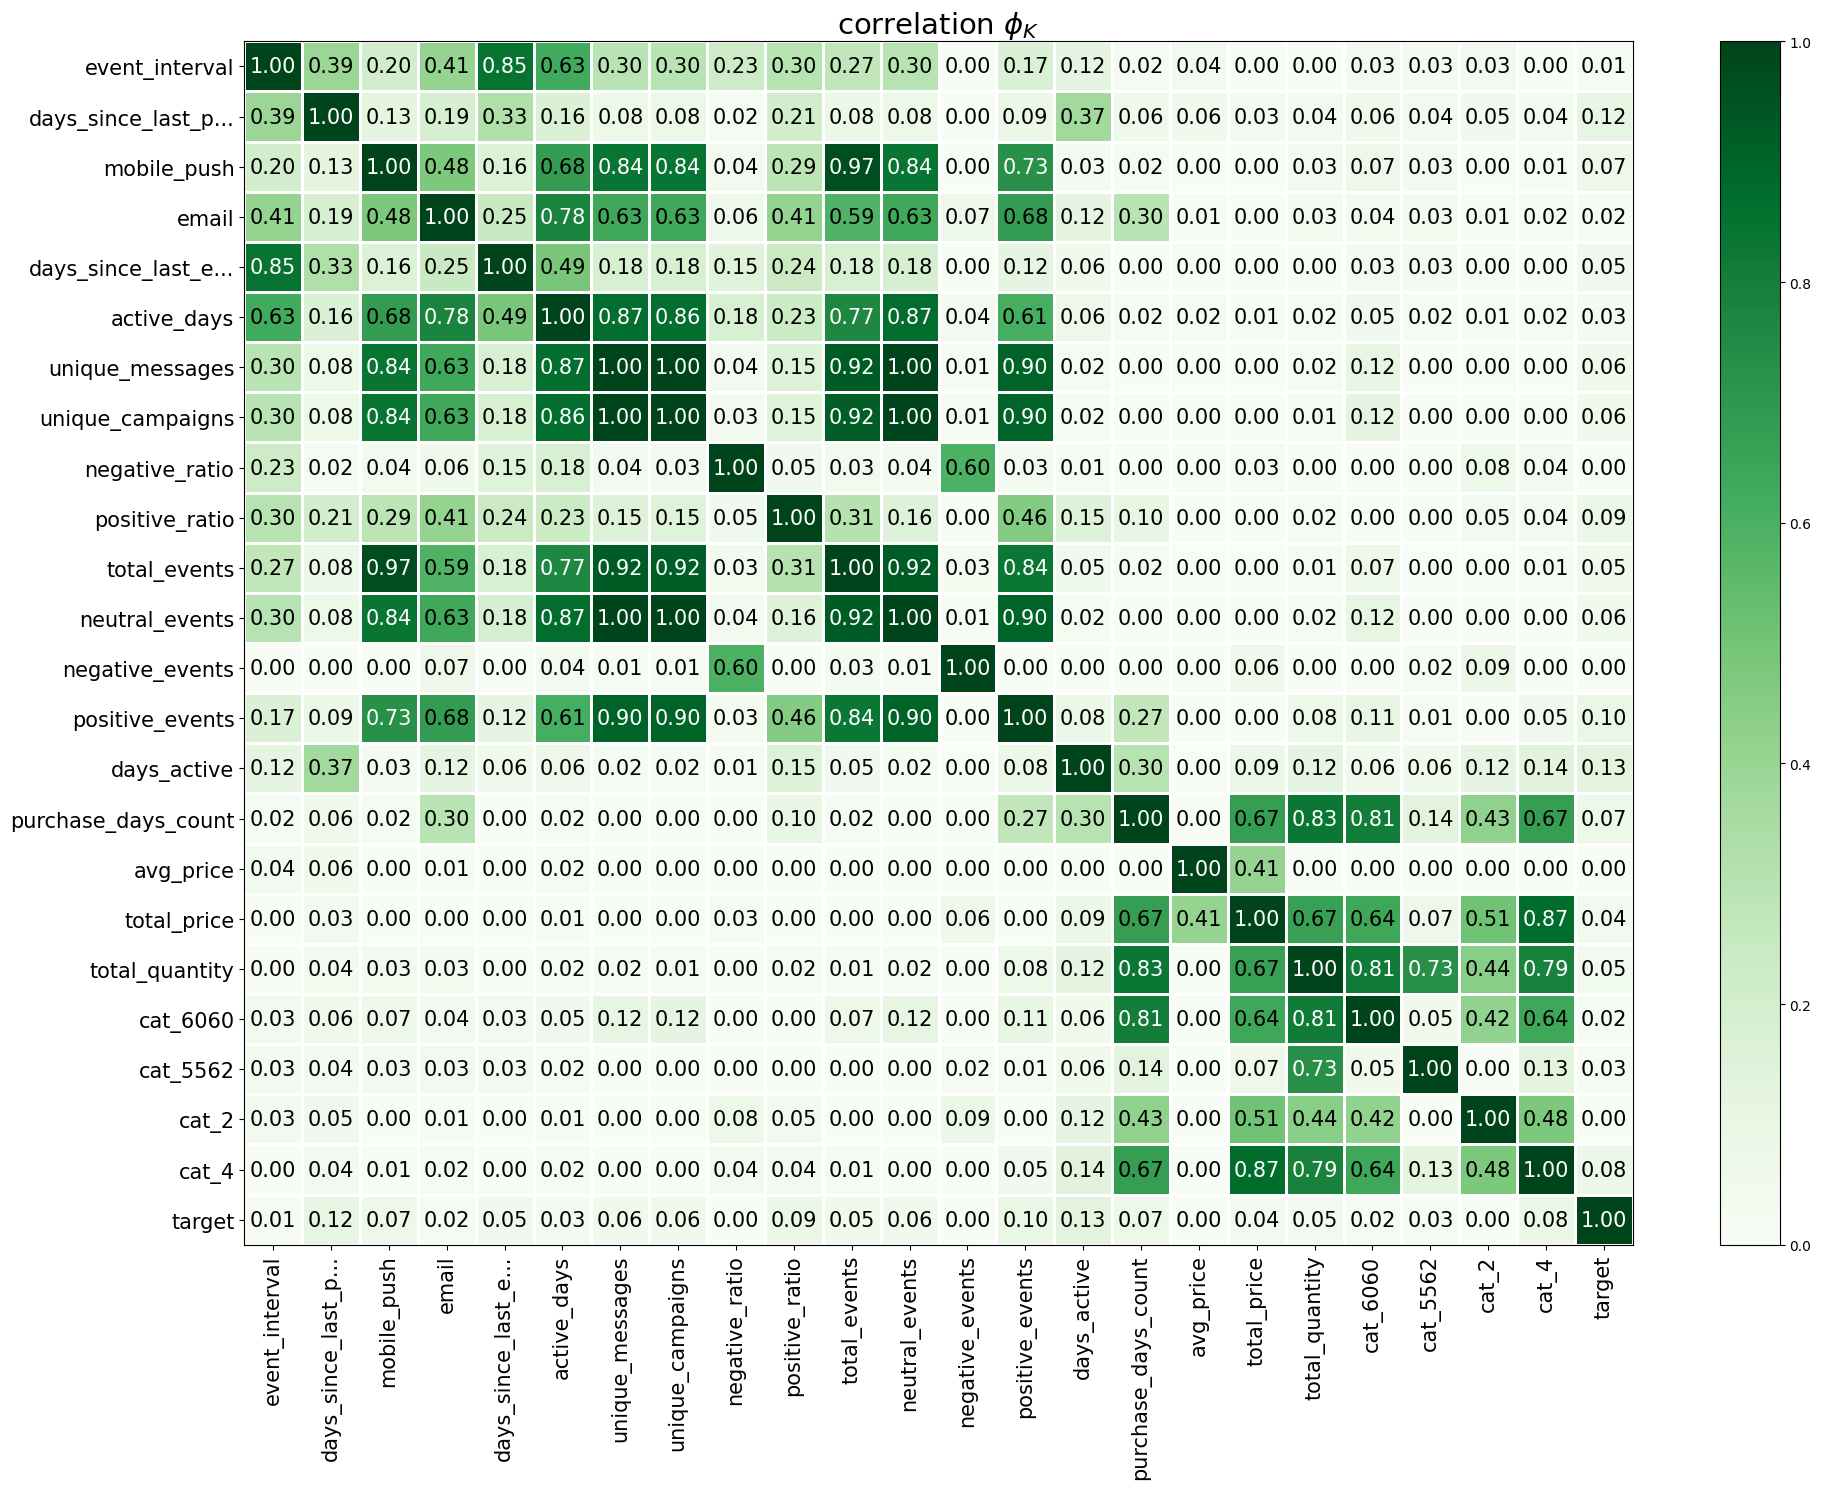

In [55]:
df_for_matrix = final_with_target.drop('client_id', axis=1)
exclude_cols = ['target', 'has_messages', 'has_purchases']
interval_cols = [col for col in df_for_matrix.columns if col not in exclude_cols]
phik_matrix = df_for_matrix.phik_matrix(interval_cols = interval_cols)
plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

In [56]:
# Уберу мультиколлинеарные признаки
final_with_target = final_with_target.drop(
    columns=[
        'total_events',
        'unique_messages',
        'unique_campaigns',
        'neutral_events',
    ]
)

In [57]:
# Удалю также признаки, у которых корреляция с таргетом 0,00 или 0,01:
final_with_target = final_with_target.drop(
    columns=[
        'negative_ratio',
        'avg_price',
        'negative_events',
        'event_interval'
    ]
)

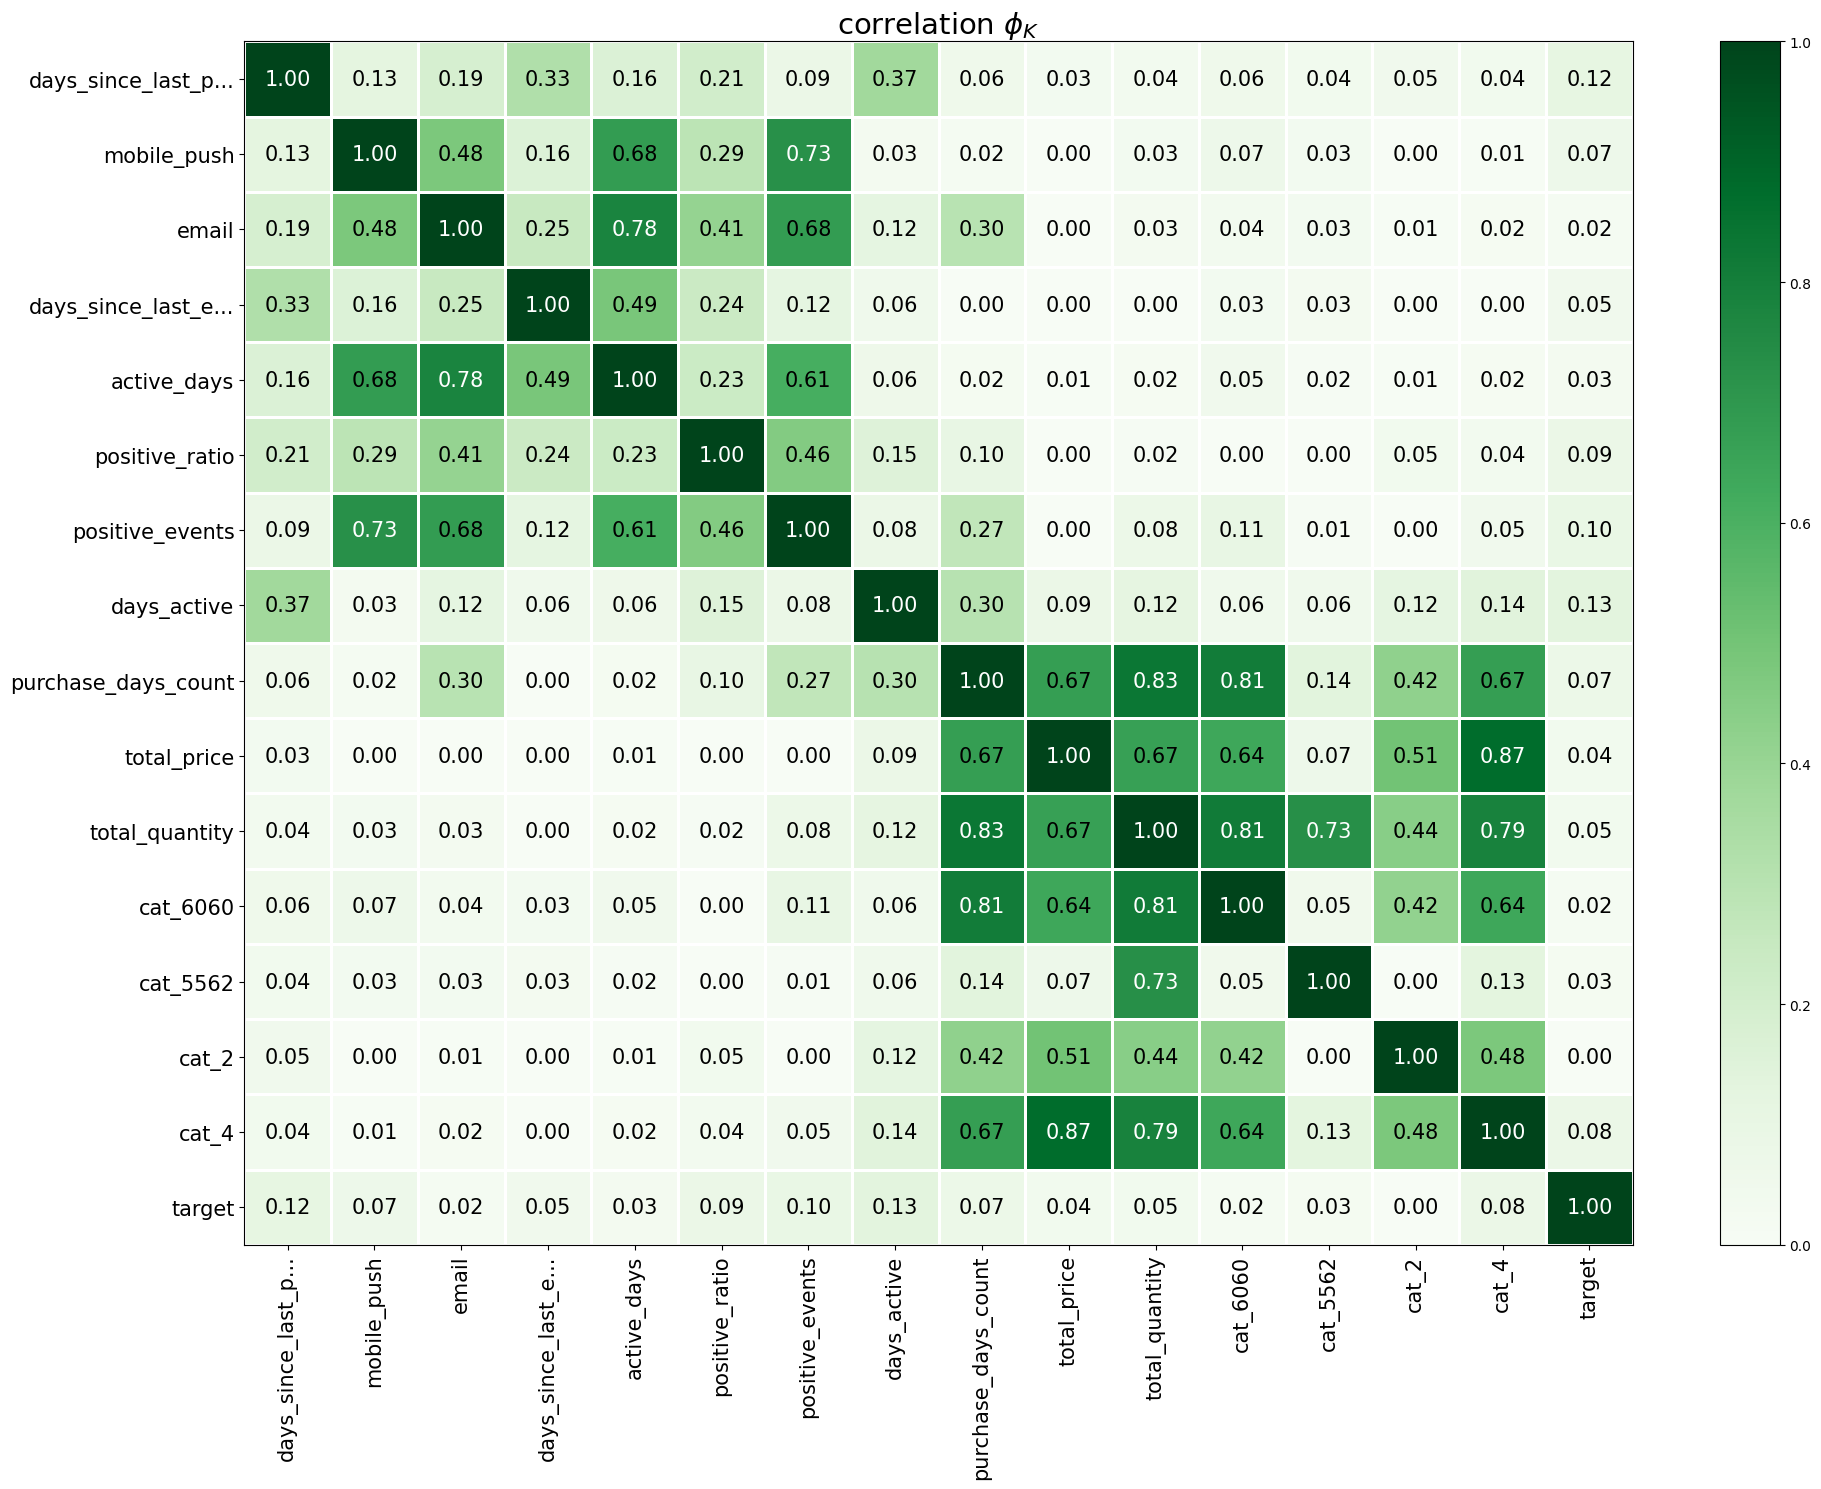

In [58]:
df_for_matrix = final_with_target.drop('client_id', axis=1)
exclude_cols = ['target', 'has_messages', 'has_purchases']
interval_cols = [col for col in df_for_matrix.columns if col not in exclude_cols]
phik_matrix = df_for_matrix.phik_matrix(interval_cols = interval_cols)
plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Остальные фичи оставлю, хотя можно еще кое-что убрать. Но посмотрю как будет работать модель на этих данных.  Далее посмотрю данные на графиках. Сначала я визуализировала данные отдельными графиками, даже удаляла выбросы (по сути вип-клиентов), мне они не нравились, но потом передумала и оставила все как есть. Бустинговые модели итак сработают, а для регрессии я потом в модели применю регуляризацию. А для видуализации применила компактные графики. Совсем не визуализировать данные как-то странно, во всех проектах это есть.

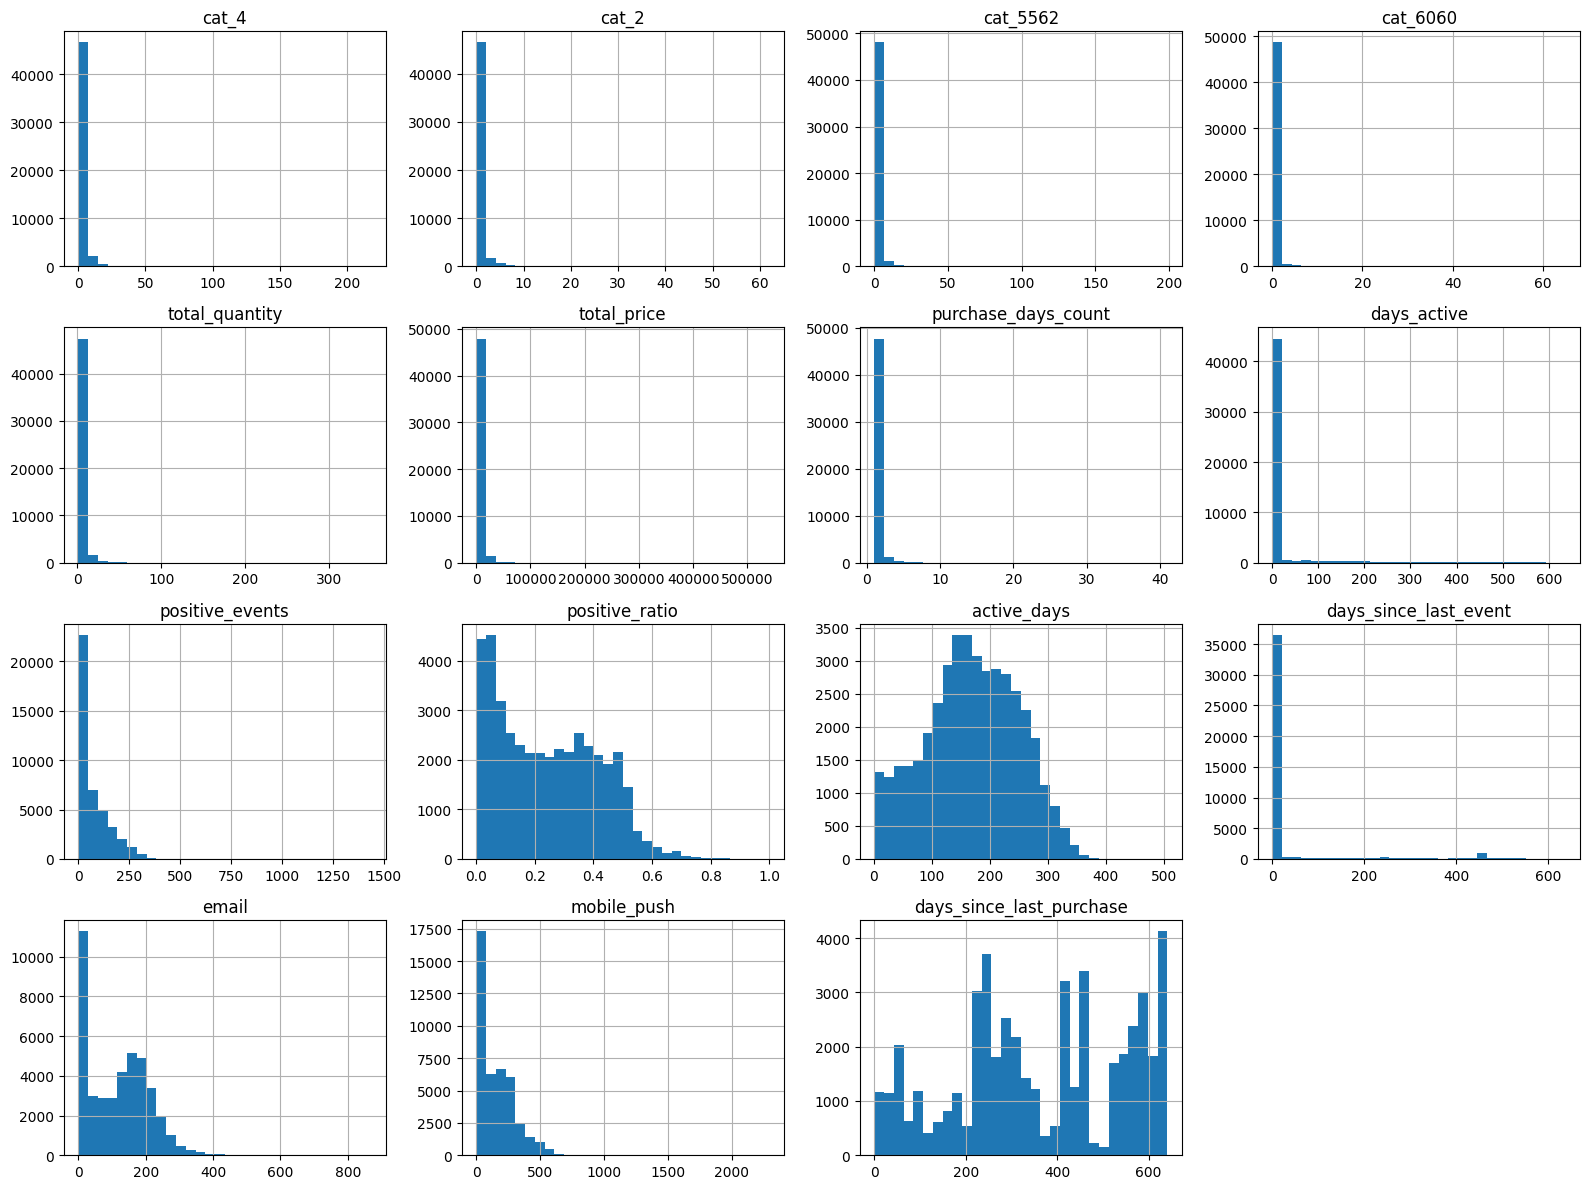

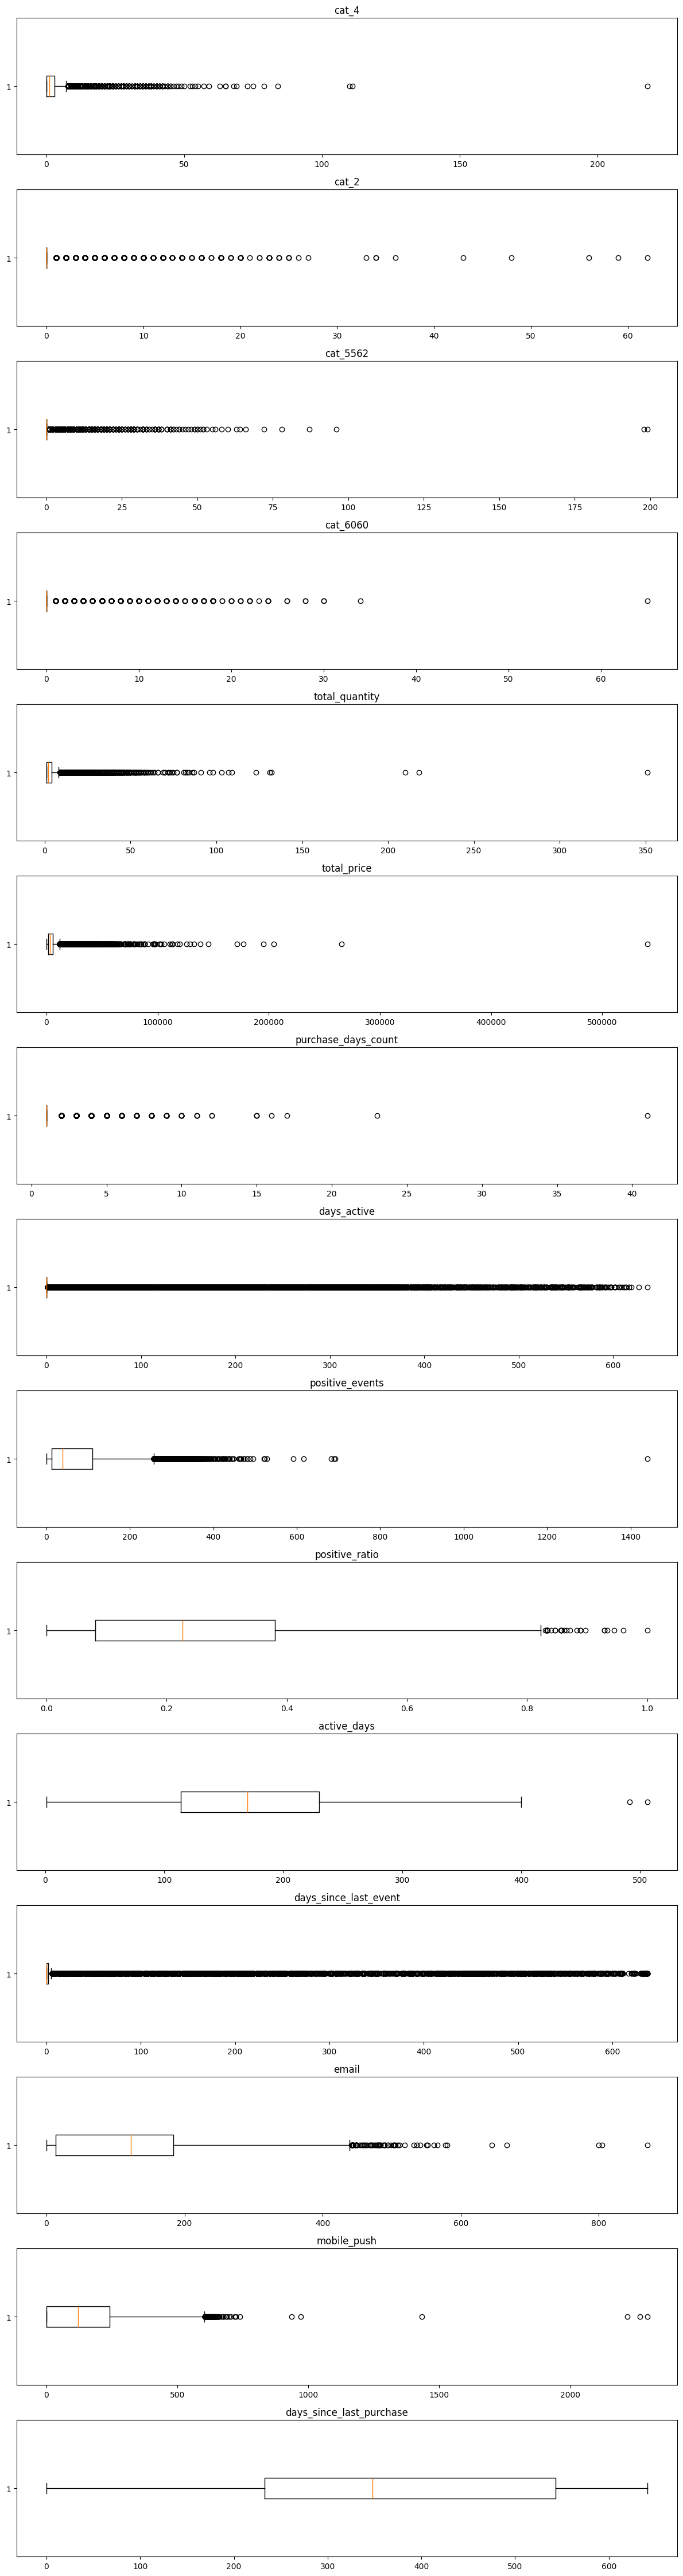

In [59]:
# Для построения графиков уберу client_id и target
num_cols = [c for c in final_with_target.select_dtypes(include=['number']).columns
            if c not in ('client_id', 'target')]

# Гистограммы
final_with_target[num_cols].hist(bins=30, figsize=(16, 12))
plt.tight_layout()
plt.show()

# Боксплоты
fig, axes = plt.subplots(len(num_cols), 1, figsize=(12, 3*len(num_cols)))
for ax, col in zip(axes, num_cols):
    ax.boxplot(final_with_target[col].dropna(), vert=False)
    ax.set_title(col)
plt.tight_layout()
plt.show()

Тут все видно на графиках. Но выбросы естесственны, это вполне может быть, что кто-то из клиентов покупает очень часто товары из одной категории, или один из коиентов покупает очень много и т.д. А то, что большинство клиентов не реагируют на рассылки и просто ничего не покупают - тоже нормально. Это как раз отображают высокие стоолбцы ближе к значению нуля.

# 5.Построение бустинговых моделей

In [60]:
RANDOM_STATE = 42

In [61]:
# Уберу также id клиентов, потому что это не признак
X = final_with_target.drop(['target', 'client_id'], axis=1)
y = final_with_target['target']

In [62]:
print(y.value_counts())

target
0    48888
1      961
Name: count, dtype: int64


В данных очень сильный дисбаланс классов. Итогом моих размышлений стало то, что я не буду делать выравнивание до построения моделей, просто применю class_weight в моделях, и посмотрю как они сработают. А также я не стала заменять пропуски нулями, так как бустинговые модели умеют с ними работать, а для регрессии напишу пайплайн подготовки данных

In [63]:
# Разбью выборку с валидацией, чтобы сравнить метрику на трейн и валидации
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=RANDOM_STATE, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

In [64]:
# Построю модель CatBoost с проверкой качества на валидации
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

cat = CatBoostClassifier(
    random_state=RANDOM_STATE,
    class_weights=class_weights,
    iterations=1500,
    learning_rate=0.01,
    depth=4,
    l2_leaf_reg=20,
    eval_metric='AUC',
    verbose=100
)

cat.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=50,
    verbose=0
)

y_train_pred = cat.predict_proba(X_train)[:, 1]
y_val_pred   = cat.predict_proba(X_val)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_train, y_train_pred))
print("Val ROC-AUC:", roc_auc_score(y_val, y_val_pred))

Train ROC-AUC: 0.8316187052145037
Val ROC-AUC: 0.7521759093543329


Модель переобучена, и даже меняя параметры она все равно переобучена получается больш или меньше. Оставлю так, попробую другие модели. Если везде будет плохо - буду менять вто-то в признаках, может еще удалю что-нибудь

In [65]:
# Построю модель LightGMB с проверкой качества на валидации
lgb_model = lgb.LGBMClassifier(
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_estimators=5000,
    learning_rate=0.02,
    num_leaves=31,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1
)

callbacks = [
    lgb.early_stopping(stopping_rounds=100, verbose=False),
    lgb.log_evaluation(period=0)
]

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=callbacks
)

y_tr = lgb_model.predict_proba(X_train)[:, 1]
y_va = lgb_model.predict_proba(X_val)[:, 1]
print("Train ROC-AUC:", roc_auc_score(y_train, y_tr))
print("Val   ROC-AUC:", roc_auc_score(y_val,   y_va))

[LightGBM] [Info] Number of positive: 577, number of negative: 29332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2491
[LightGBM] [Info] Number of data points in the train set: 29909, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Train ROC-AUC: 0.9283427330831093
Val   ROC-AUC: 0.7418111768766619


Метрика, конечно, получается выше 0,7, но тут оочень большое переобучение. Так не годится

# 5.Построение иных моделей

In [66]:
# Напишу функцию для вывода метрики:
def print_auc(model, X_tr, y_tr, X_va, y_va, name):
    p_tr = model.predict_proba(X_tr)[:, 1]
    p_va = model.predict_proba(X_va)[:, 1]
    print(f"{name}  |  Train AUC: {roc_auc_score(y_tr, p_tr):.4f}   Val AUC: {roc_auc_score(y_va, p_va):.4f}")

# Попробую модель Decision Tree.
dt_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('dt', DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE))
])

# Перебор возьму небольшой
dt_grid = {
    'dt__max_depth': [3, 4, 5],
    'dt__min_samples_leaf': [5, 10, 20]
}

dt_cv = GridSearchCV(
    estimator=dt_pipe,
    param_grid=dt_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=0
)
dt_cv.fit(X_train, y_train)
best_dt = dt_cv.best_estimator_
print("Decision Tree best params:", dt_cv.best_params_)
print_auc(best_dt, X_train, y_train, X_val, y_val, "Decision Tree")

Decision Tree best params: {'dt__max_depth': 3, 'dt__min_samples_leaf': 5}
Decision Tree  |  Train AUC: 0.7235   Val AUC: 0.6788


In [67]:
# Модель лог. регрессии
lr_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler(with_mean=False)),
    ('lr', LogisticRegression(
        class_weight='balanced',
        penalty='l2',
        solver='lbfgs',
        max_iter=1000,
        random_state=RANDOM_STATE
    ))
])

lr_grid = {
    'lr__C': [0.01, 0.1, 1.0]
}

lr_cv = GridSearchCV(
    estimator=lr_pipe,
    param_grid=lr_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=0
)
lr_cv.fit(X_train, y_train)
best_lr = lr_cv.best_estimator_
print("LogReg best params:", lr_cv.best_params_)
print_auc(best_lr, X_train, y_train, X_val, y_val, "Logistic Regression")

LogReg best params: {'lr__C': 0.1}
Logistic Regression  |  Train AUC: 0.7449   Val AUC: 0.7295


Получилось, что самая простая модель хорошо уловила закономерности в данных, учитывая, что я многие фичи создавала соотношением, то это и верно, зависимость линейная. А вот сложные модели переобучаются сильно, при том, что метрика на валидации примерно одинакова. Так что выиграла модель логистической регрессии.

In [68]:
# Предсказания на тесте:
y_test_pred_proba = best_lr.predict_proba(X_test)[:, 1]

# ROC-AUC на тесте:
test_auc = roc_auc_score(y_test, y_test_pred_proba)
print(f"Final Test ROC-AUC (Logistic Regression): {test_auc:.4f}")

Final Test ROC-AUC (Logistic Regression): 0.7087


Метрика получилась 0,7, что впринципе нормально. Думаю если повозиться в данными или параметрами, то еще можно добиться улучшений, но итак уже приемлемый результат.

# 5.Важность признаков

Важность признаков люблю смотреть через SHAP, но честно сказать он для меня сложноват, а времени в обрез (я в одном из проектов с ним несколько часов возилась), поэтому я без зазрения совести воспользовалась помощниками, уж простите меня. Зато получила важные признаки.

In [69]:
imputer = best_lr.named_steps['imputer']
scaler  = best_lr.named_steps.get('scaler', None)
lr      = best_lr.named_steps['lr']

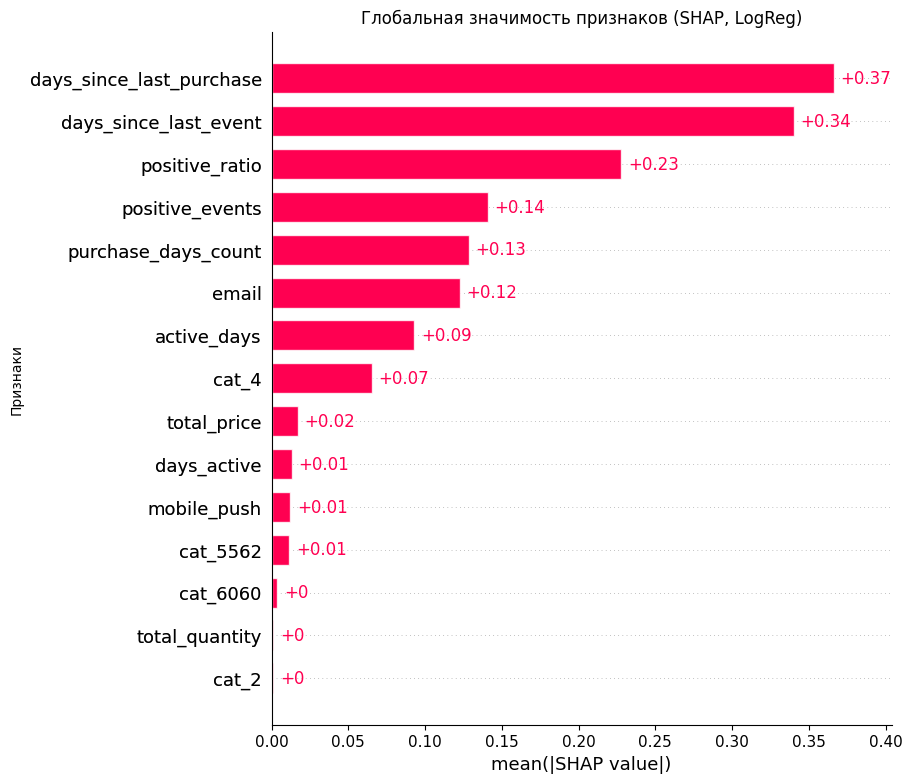

In [70]:
X_va_tr = best_lr[:-1].transform(X_val)
feature_names = X.columns


explainer = shap.Explainer(best_lr[-1], X_va_tr, feature_names=feature_names)


X_va_tr_df = pd.DataFrame(X_va_tr, columns=feature_names)

sv = explainer(X_va_tr)

if isinstance(sv, shap._explanation.Explanation):
    shap_exp = sv
else:
    shap_exp = shap.Explanation(
        values=sv,
        base_values=explainer.expected_value,
        data=X_va_tr_df,
        feature_names=feature_names
    )

shap.plots.bar(shap_exp, max_display=17, show=False)
plt.ylabel('Признаки')
plt.title('Глобальная значимость признаков (SHAP, LogReg)')
plt.show()

Итого самыми важными признаками у нас являются к **Количество дней с
последней покупки**, **дней с последнего действая с сообщением**, **соотношение положительных событий к общему количеству событий** . Модель нам показывает, что те, кто недавно покупал, недавно реагировал на сообщения и реагировал позитивно — тот и купит снова, примерно так. И это логичные выводы.

**Вывод по проекту**  В рамках работы была решена задача прогнозирования отклика клиентов интернет-магазина на рассылки.
Проведена предобработка данных, построены новые признаки, учтён сильный дисбаланс классов. Для сравнения обучены несколько моделей (CatBoost, LightGBM, Decision Tree, Logistic Regression).

Результаты показали, что лучше всего с задачей справилась логистическая регрессия, которая продемонстрировала устойчивое качество на валидационной выборке без переобучения. Сложные модели показали более высокие результаты на трейне, но переобучались.

Таким образом, итоговой моделью для решения задачи была выбрана логистическая регрессия. Финальная модель — Logistic Regression, которая на тестовой выборке показала качество ROC-AUC = 0.7087.